In [1]:
# Import libraries and set desired options
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Read training and test sets, sort train set by session start time.**

In [3]:
train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=['time1'])
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=['time1'])


times = ['time%s' % i for i in range(1, 11)]
train_df.fillna(0)
test_df.fillna(0)

# times column type conversion
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')
test_df = test_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


**Transform data into format which can be fed into `CountVectorizer`**

In [4]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites].fillna(0).astype('int').to_csv('train_sessions_text.txt', 
                                               sep=' ', 
                       index=None, header=None)
test_df[sites].fillna(0).astype('int').to_csv('test_sessions_text.txt', 
                                              sep=' ', 
                       index=None, header=None)

In [5]:
!head -5 train_sessions_text.txt

56 55 0 0 0 0 0 0 0 0
56 55 56 55 0 0 0 0 0 0
946 946 951 946 946 945 948 784 949 946
945 948 949 948 945 946 947 945 946 946
947 950 948 947 950 952 946 951 946 947


**Fit `CountVectorizer` and transfrom data with it.**

In [6]:
%%time
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
X_train.shape, X_test.shape

CPU times: user 12 s, sys: 269 ms, total: 12.2 s
Wall time: 12.2 s


**Save train targets into a separate vector.**

In [7]:
y_train = train_df['target'].astype('int').values

**We'll be performing time series cross-validation, see `sklearn` [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) and [this dicussion](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection) on StackOverflow.**

In [8]:
time_split = TimeSeriesSplit(n_splits=10)

<img src="https://habrastorage.org/webt/8i/5k/vx/8i5kvxrehatyvf-l3glz_-ymhtw.png" />

In [9]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

**Now we'll add some time features: indicators of month, week, hour and etc.**

In [10]:
train_df['month'] = train_df['time1'].apply(lambda ts: ts.month)

train_df['start_hour'] = train_df['time1'].apply(lambda ts: ts.hour)

train_df['day_of_year'] = train_df['time1'].apply(lambda ts: ts.timetuple().tm_yday)
train_df['day_of_week'] = train_df['time1'].apply(lambda ts: ts.date().weekday())

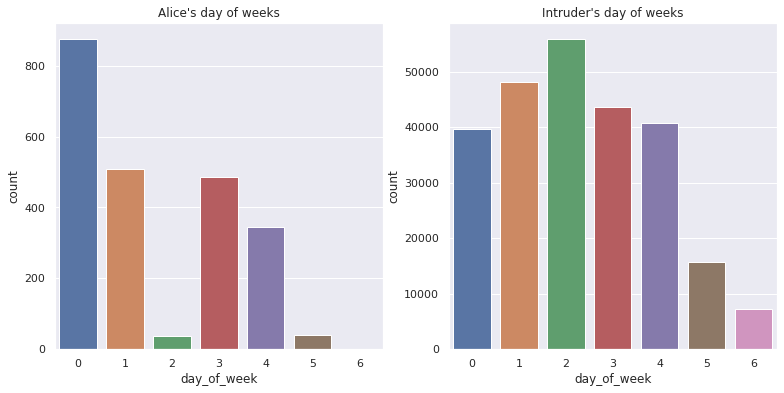

In [11]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Alice\'s day of weeks')
sns.countplot(x="day_of_week", data=train_df[train_df.target==1]) # Alice

plt.subplot(1, 3, 2)
plt.title('Intruder\'s day of weeks')
sns.countplot(x="day_of_week", data=train_df[train_df.target==0]) # Not Alice

**Alice is offline due wednesday and weekend.**

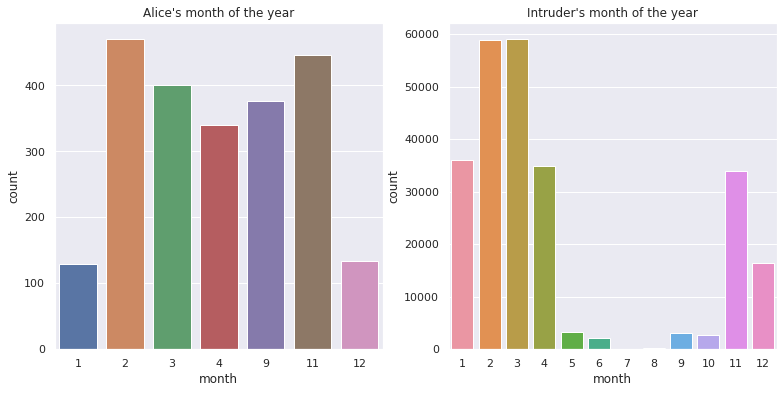

In [12]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Alice\'s month of the year')
sns.countplot(x="month", data=train_df[train_df.target==1]) # Alice

plt.subplot(1, 3, 2)
plt.title('Intruder\'s month of the year')
sns.countplot(x="month", data=train_df[train_df.target==0]) # Not Alice

**Alice is active at spring and some autumn months.**

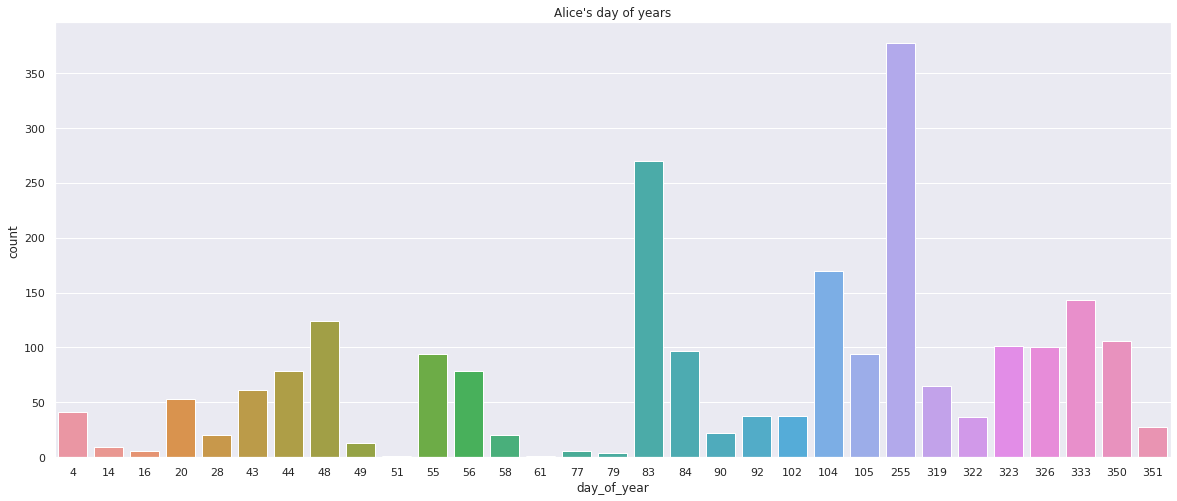

In [13]:
plt.figure(figsize=(20, 8))

plt.title('Alice\'s day of years')
sns.countplot(x="day_of_year", data=train_df[train_df['target']==1])

In [14]:
# set with the most active Alice's days
day_of_year = {104, 333, 48, 350, 323, 326, 84, 55, 105, 44, 56, 319, 43, 20, 322, 351, 4, 92, 102, 90, 28, 58}

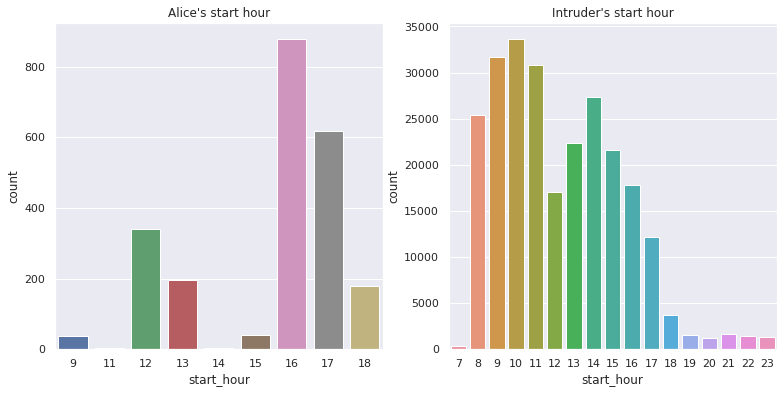

In [15]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
plt.title('Alice\'s start hour')
sns.countplot(x="start_hour", data=train_df[train_df.target==1]) # Alice

plt.subplot(1, 3, 2)
plt.title('Intruder\'s start hour')
sns.countplot(x="start_hour", data=train_df[train_df.target==0]) # Not Alice

**Alice is most active in 12, 13, 16, 17 and 18 hours.**

In [16]:
def add_time_features(df, X_sparse):
    activity_day_year = df['time1'].apply(lambda ts: 1 if ts.timetuple().tm_yday in day_of_year else 0)
    activity_day_week = df['time1'].apply(lambda ts: 1 if ts.dayofweek in [0, 1, 3, 4] else 0)
    month = df['time1'].apply(lambda ts: 1 if ts.month in [2, 3, 4, 9, 11] else 0)
    alice_hours = df['time1'].apply(lambda ts: 1 if ts.hour in [12, 13, 16, 17, 18] else 0)
    intruder_hours = df['time1'].apply(lambda ts: 1 if (ts.date().weekday() in (0, 1, 2, 3, 4)) &
                                             ((ts.hour>=8)&(ts.hour<=17)) else 0)
    
    X = hstack([X_sparse, activity_day_year.values.reshape(-1, 1), intruder_hours.values.reshape(-1, 1),
                activity_day_week.values.reshape(-1, 1), month.values.reshape(-1, 1), alice_hours.values.reshape(-1, 1)])
    
    return X

In [17]:
%%time
X_train_new = add_time_features(train_df, X_train)
X_test_new = add_time_features(test_df, X_test)

CPU times: user 6.97 s, sys: 32.5 ms, total: 7 s
Wall time: 7 s


In [18]:
X_train_new.shape, X_test_new.shape

((253561, 50005), (82797, 50005))

**Perform time series cross-validation with logistic regression.**

In [21]:
%%time
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

cv_scores = cross_val_score(logit, X_train_new, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1) 

CPU times: user 2min 41s, sys: 1min 43s, total: 4min 25s
Wall time: 1min 11s


In [22]:
cv_scores, cv_scores.mean()

(array([0.88474916, 0.86107931, 0.93963517, 0.98503973, 0.97081113,
        0.97553006, 0.94683406, 0.95634101, 0.95598278, 0.97759887]),
 0.9453601276072086)

**Now we tune regularization parameter `C`.**

In [23]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [24]:
%%time
logit_grid_searcher.fit(X_train_new, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 16.7min finished


CPU times: user 38 s, sys: 24 s, total: 1min 2s
Wall time: 17min 1s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=

In [25]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9464664365857207, {'C': 0.5994842503189409})

In [26]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test_new)[:, 1]
write_to_submission_file(logit_test_pred3, 'subm3.csv') 